In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive')

In [ ]:
!pwd

/content/drive/My Drive


In [ ]:
!pip3 install tensorboardX
!pip3 install torchfile

     |████████████████████████████████| 317kB 9.9MB/s 
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5712 sha256=9e3ac1a35e14508d3078b76d746042d34c0e20b194ebecd87fd4c5845e92338a
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchfile


In [ ]:
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch
import os
import sys
import shutil
from torch import nn
import torch.nn.functional as F
import tensorboardX
import math
import torchvision.utils as vutils
import yaml
import numpy as np
import torch.nn.init as init
import time
import torchfile
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.utils.data as data
import os.path
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
config = {'image_save_iter': 10000,'image_display_iter': 500,'display_size': 16,'snapshot_save_iter': 1000,'log_iter': 10,'max_iter': 1000000,'batch_size': 1,'weight_decay': 0.0001,'beta1': 0.5,
          'beta2': 0.999,'init': 'kaiming','lr': 0.000001,'lr_policy': 'step','step_size': 100000,'gamma': 0.5,'gan_w': 1,'recon_x_w': 10,'recon_h_w': 0,'recon_kl_w': 0.01,'recon_x_cyc_w': 10,'recon_kl_cyc_w': 0.01,
          'vgg_w': 0,'gen':{'dim': 64,'activ': 'relu','n_downsample': 2,'n_res': 4,'pad_type': 'reflect'},'dis':{'dim': 64,'norm': 'none','activ': 'lrelu','n_layer': 4,'gan_type': 'lsgan','num_scales': 3,'pad_type': 'reflect'},
          'input_dim_a': 3,'input_dim_b': 3,'num_workers': 8,'new_size': 256,'crop_image_height': 256,'crop_image_width': 256,'data_root': 'Rgb-Thermal/'}

In [ ]:
def default_loader(path):
    return Image.open(path).convert('RGB')


def default_flist_reader(flist):
    """
    flist format: impath label\nimpath label\n ...(same to caffe's filelist)
    """
    imlist = []
    with open(flist, 'r') as rf:
        for line in rf.readlines():
            impath = line.strip()
            imlist.append(impath)

    return imlist


class ImageFilelist(data.Dataset):
    def __init__(self, root, flist, transform=None,
                 flist_reader=default_flist_reader, loader=default_loader):
        self.root = root
        self.imlist = flist_reader(flist)
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        impath = self.imlist[index]
        img = self.loader(os.path.join(self.root, impath))
        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.imlist)


class ImageLabelFilelist(data.Dataset):
    def __init__(self, root, flist, transform=None,
                 flist_reader=default_flist_reader, loader=default_loader):
        self.root = root
        self.imlist = flist_reader(os.path.join(self.root, flist))
        self.transform = transform
        self.loader = loader
        self.classes = sorted(list(set([path.split('/')[0] for path in self.imlist])))
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.imgs = [(impath, self.class_to_idx[impath.split('/')[0]]) for impath in self.imlist]

    def __getitem__(self, index):
        impath, label = self.imgs[index]
        img = self.loader(os.path.join(self.root, impath))
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images


class ImageFolder(data.Dataset):

    def __init__(self, root, transform=None, return_paths=False,
                 loader=default_loader):
        imgs = sorted(make_dataset(root))
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in: " + root + "\n"
                               "Supported image extensions are: " +
                               ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.transform = transform
        self.return_paths = return_paths
        self.loader = loader

    def __getitem__(self, index):
        path = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.return_paths:
            return img, path
        else:
            return img

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_all_data_loaders(conf):
    batch_size = conf['batch_size']
    num_workers = conf['num_workers']
    if 'new_size' in conf:
        new_size_a = new_size_b = conf['new_size']
    else:
        new_size_a = conf['new_size_a']
        new_size_b = conf['new_size_b']
    height = conf['crop_image_height']
    width = conf['crop_image_width']

    if 'data_root' in conf:
        train_loader_a = get_data_loader_folder(os.path.join(conf['data_root'], 'trainA'), batch_size, True,
                                              new_size_a, height, width, num_workers, True)
        test_loader_a = get_data_loader_folder(os.path.join(conf['data_root'], 'testA'), batch_size, False,
                                             new_size_a, new_size_a, new_size_a, num_workers, True)
        train_loader_b = get_data_loader_folder(os.path.join(conf['data_root'], 'trainB'), batch_size, True,
                                              new_size_b, height, width, num_workers, True)
        test_loader_b = get_data_loader_folder(os.path.join(conf['data_root'], 'testB'), batch_size, False,
                                             new_size_b, new_size_b, new_size_b, num_workers, True)
    else:
        train_loader_a = get_data_loader_list(conf['data_folder_train_a'], conf['data_list_train_a'], batch_size, True,
                                                new_size_a, height, width, num_workers, True)
        test_loader_a = get_data_loader_list(conf['data_folder_test_a'], conf['data_list_test_a'], batch_size, False,
                                                new_size_a, new_size_a, new_size_a, num_workers, True)
        train_loader_b = get_data_loader_list(conf['data_folder_train_b'], conf['data_list_train_b'], batch_size, True,
                                                new_size_b, height, width, num_workers, True)
        test_loader_b = get_data_loader_list(conf['data_folder_test_b'], conf['data_list_test_b'], batch_size, False,
                                                new_size_b, new_size_b, new_size_b, num_workers, True)
    return train_loader_a, train_loader_b, test_loader_a, test_loader_b


def get_data_loader_list(root, file_list, batch_size, train, new_size=None,
                           height=256, width=256, num_workers=4, crop=True):
    transform_list = [transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))]
    #transform_list = [transforms.RandomCrop((height, width))] + transform_list if crop else transform_list
    #transform_list = [transforms.Resize(new_size)] + transform_list if new_size is not None else transform_list
    transform_list = [transforms.RandomHorizontalFlip()] + transform_list if train else transform_list
    transform = transforms.Compose(transform_list)
    dataset = ImageFilelist(root, file_list, transform=transform)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, drop_last=True, num_workers=num_workers)
    return loader

def get_data_loader_folder(input_folder, batch_size, train, new_size=None,
                           height=256, width=256, num_workers=4, crop=True):
    transform_list = [transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))]
    #transform_list = [transforms.RandomCrop((height, width))] + transform_list if crop else transform_list
    #transform_list = [transforms.Resize(new_size)] + transform_list if new_size is not None else transform_list
    transform_list = [transforms.RandomHorizontalFlip()] + transform_list if train else transform_list
    transform = transforms.Compose(transform_list)
    dataset = ImageFolder(input_folder, transform=transform)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, drop_last=True, num_workers=num_workers)
    return loader

def get_config(config):
    with open(config, 'r') as stream:
        return yaml.load(stream)


def eformat(f, prec):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%d"%(mantissa, int(exp))


def __write_images(image_outputs, display_image_num, file_name):
    image_outputs = [images.expand(-1, 3, -1, -1) for images in image_outputs] # expand gray-scale images to 3 channels
    image_tensor = torch.cat([images[:display_image_num] for images in image_outputs], 0)
    image_grid = vutils.make_grid(image_tensor.data, nrow=display_image_num, padding=0, normalize=True)
    vutils.save_image(image_grid, file_name, nrow=1)


def write_2images(image_outputs, display_image_num, image_directory, postfix):
    n = len(image_outputs)
    __write_images(image_outputs[0:n//2], display_image_num, '%s/gen_a2b_%s.jpg' % (image_directory, postfix))
    __write_images(image_outputs[n//2:n], display_image_num, '%s/gen_b2a_%s.jpg' % (image_directory, postfix))


def prepare_sub_folder(output_directory):
    image_directory = os.path.join(output_directory, 'images')
    if not os.path.exists(image_directory):
        print("Creating directory: {}".format(image_directory))
        os.makedirs(image_directory)
    checkpoint_directory = os.path.join(output_directory, 'checkpoints')
    if not os.path.exists(checkpoint_directory):
        print("Creating directory: {}".format(checkpoint_directory))
        os.makedirs(checkpoint_directory)
    return checkpoint_directory, image_directory


def write_one_row_html(html_file, iterations, img_filename, all_size):
    html_file.write("<h3>iteration [%d] (%s)</h3>" % (iterations,img_filename.split('/')[-1]))
    html_file.write("""
        <p><a href="%s">
          <img src="%s" style="width:%dpx">
        </a><br>
        <p>
        """ % (img_filename, img_filename, all_size))
    return


def write_html(filename, iterations, image_save_iterations, image_directory, all_size=1536):
    html_file = open(filename, "w")
    html_file.write('''
    <!DOCTYPE html>
    <html>
    <head>
      <title>Experiment name = %s</title>
      <meta http-equiv="refresh" content="30">
    </head>
    <body>
    ''' % os.path.basename(filename))
    html_file.write("<h3>current</h3>")
    write_one_row_html(html_file, iterations, '%s/gen_a2b_train_current.jpg' % (image_directory), all_size)
    write_one_row_html(html_file, iterations, '%s/gen_b2a_train_current.jpg' % (image_directory), all_size)
    for j in range(iterations, image_save_iterations-1, -1):
        if j % image_save_iterations == 0:
            write_one_row_html(html_file, j, '%s/gen_a2b_test_%08d.jpg' % (image_directory, j), all_size)
            write_one_row_html(html_file, j, '%s/gen_b2a_test_%08d.jpg' % (image_directory, j), all_size)
            write_one_row_html(html_file, j, '%s/gen_a2b_train_%08d.jpg' % (image_directory, j), all_size)
            write_one_row_html(html_file, j, '%s/gen_b2a_train_%08d.jpg' % (image_directory, j), all_size)
    html_file.write("</body></html>")
    html_file.close()


def write_loss(iterations, trainer, train_writer):
    members = [attr for attr in dir(trainer) \
               if not callable(getattr(trainer, attr)) and not attr.startswith("__") and ('loss' in attr or 'grad' in attr or 'nwd' in attr)]
    for m in members:
        train_writer.add_scalar(m, getattr(trainer, m), iterations + 1)


def slerp(val, low, high):
    """
    original: Animating Rotation with Quaternion Curves, Ken Shoemake
    https://arxiv.org/abs/1609.04468
    Code: https://github.com/soumith/dcgan.torch/issues/14, Tom White
    """
    omega = np.arccos(np.dot(low / np.linalg.norm(low), high / np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0 - val) * omega) / so * low + np.sin(val * omega) / so * high


def get_slerp_interp(nb_latents, nb_interp, z_dim):
    """
    modified from: PyTorch inference for "Progressive Growing of GANs" with CelebA snapshot
    https://github.com/ptrblck/prog_gans_pytorch_inference
    """

    latent_interps = np.empty(shape=(0, z_dim), dtype=np.float32)
    for _ in range(nb_latents):
        low = np.random.randn(z_dim)
        high = np.random.randn(z_dim)  # low + np.random.randn(512) * 0.7
        interp_vals = np.linspace(0, 1, num=nb_interp)
        latent_interp = np.array([slerp(v, low, high) for v in interp_vals],
                                 dtype=np.float32)
        latent_interps = np.vstack((latent_interps, latent_interp))

    return latent_interps[:, :, np.newaxis, np.newaxis]


# Get model list for resume
def get_model_list(dirname, key):
    if os.path.exists(dirname) is False:
        return None
    gen_models = [os.path.join(dirname, f) for f in os.listdir(dirname) if
                  os.path.isfile(os.path.join(dirname, f)) and key in f and ".pt" in f]
    if gen_models is None:
        return None
    gen_models.sort()
    last_model_name = gen_models[-1]
    return last_model_name


def load_vgg16(model_dir):
    """ Use the model from https://github.com/abhiskk/fast-neural-style/blob/master/neural_style/utils.py """
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    if not os.path.exists(os.path.join(model_dir, 'vgg16.weight')):
        if not os.path.exists(os.path.join(model_dir, 'vgg16.t7')):
            os.system('wget https://www.dropbox.com/s/76l3rt4kyi3s8x7/vgg16.t7?dl=1 -O ' + os.path.join(model_dir, 'vgg16.t7'))
        vgglua = torchfile.load(os.path.join(model_dir, 'vgg16.t7'))
        vgg = Vgg16()
        for (src, dst) in zip(vgglua.parameters()[0], vgg.parameters()):
            dst.data[:] = src
        torch.save(vgg.state_dict(), os.path.join(model_dir, 'vgg16.weight'))
    vgg = Vgg16()
    vgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
    return vgg


def vgg_preprocess(batch):
    tensortype = type(batch.data)
    (r, g, b) = torch.chunk(batch, 3, dim = 1)
    batch = torch.cat((b, g, r), dim = 1) # convert RGB to BGR
    batch = (batch + 1) * 255 * 0.5 # [-1, 1] -> [0, 255]
    mean = tensortype(batch.data.size()).cuda()
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    batch = batch.sub(Variable(mean)) # subtract mean
    return batch


def get_scheduler(optimizer, hyperparameters, iterations=-1):
    if 'lr_policy' not in hyperparameters or hyperparameters['lr_policy'] == 'constant':
        scheduler = None # constant scheduler
    elif hyperparameters['lr_policy'] == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=hyperparameters['step_size'],
                                        gamma=hyperparameters['gamma'], last_epoch=iterations)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', hyperparameters['lr_policy'])
    return scheduler


def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find('Linear') == 0) and hasattr(m, 'weight'):
            # print m.__class__.__name__
            if init_type == 'gaussian':
                init.normal_(m.weight.data, 0.0, 0.02)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)

    return init_fun


class Timer:
    def __init__(self, msg):
        self.msg = msg
        self.start_time = None

    def __enter__(self):
        self.start_time = time.time()

    def __exit__(self, exc_type, exc_value, exc_tb):
        print(self.msg % (time.time() - self.start_time))


def pytorch03_to_pytorch04(state_dict_base):
    def __conversion_core(state_dict_base):
        state_dict = state_dict_base.copy()
        for key, value in state_dict_base.items():
            if key.endswith(('enc.model.0.norm.running_mean',
                             'enc.model.0.norm.running_var',
                             'enc.model.1.norm.running_mean',
                             'enc.model.1.norm.running_var',
                             'enc.model.2.norm.running_mean',
                             'enc.model.2.norm.running_var',
                             'enc.model.3.model.0.model.1.norm.running_mean',
                             'enc.model.3.model.0.model.1.norm.running_var',
                             'enc.model.3.model.0.model.0.norm.running_mean',
                             'enc.model.3.model.0.model.0.norm.running_var',
                             'enc.model.3.model.1.model.1.norm.running_mean',
                             'enc.model.3.model.1.model.1.norm.running_var',
                             'enc.model.3.model.1.model.0.norm.running_mean',
                             'enc.model.3.model.1.model.0.norm.running_var',
                             'enc.model.3.model.2.model.1.norm.running_mean',
                             'enc.model.3.model.2.model.1.norm.running_var',
                             'enc.model.3.model.2.model.0.norm.running_mean',
                             'enc.model.3.model.2.model.0.norm.running_var',
                             'enc.model.3.model.3.model.1.norm.running_mean',
                             'enc.model.3.model.3.model.1.norm.running_var',
                             'enc.model.3.model.3.model.0.norm.running_mean',
                             'enc.model.3.model.3.model.0.norm.running_var',
                             'dec.model.0.model.0.model.1.norm.running_mean',
                             'dec.model.0.model.0.model.1.norm.running_var',
                             'dec.model.0.model.0.model.0.norm.running_mean',
                             'dec.model.0.model.0.model.0.norm.running_var',
                             'dec.model.0.model.1.model.1.norm.running_mean',
                             'dec.model.0.model.1.model.1.norm.running_var',
                             'dec.model.0.model.1.model.0.norm.running_mean',
                             'dec.model.0.model.1.model.0.norm.running_var',
                             'dec.model.0.model.2.model.1.norm.running_mean',
                             'dec.model.0.model.2.model.1.norm.running_var',
                             'dec.model.0.model.2.model.0.norm.running_mean',
                             'dec.model.0.model.2.model.0.norm.running_var',
                             'dec.model.0.model.3.model.1.norm.running_mean',
                             'dec.model.0.model.3.model.1.norm.running_var',
                             'dec.model.0.model.3.model.0.norm.running_mean',
                             'dec.model.0.model.3.model.0.norm.running_var',
                             )):
                del state_dict[key]
        return state_dict
    state_dict = dict()
    state_dict['a'] = __conversion_core(state_dict_base['a'])
    state_dict['b'] = __conversion_core(state_dict_base['b'])
    return state_dict

In [ ]:
class MsImageDis(nn.Module):
    # Multi-scale discriminator architecture
    def __init__(self, input_dim, params):
        super(MsImageDis, self).__init__()
        self.n_layer = params['n_layer']
        self.gan_type = params['gan_type']
        self.dim = params['dim']
        self.norm = params['norm']
        self.activ = params['activ']
        self.num_scales = params['num_scales']
        self.pad_type = params['pad_type']
        self.input_dim = input_dim
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        self.cnns = nn.ModuleList()
        for _ in range(self.num_scales):
            self.cnns.append(self._make_net())

    def _make_net(self):
        dim = self.dim
        cnn_x = []
        cnn_x += [Conv2dBlock(self.input_dim, dim, 4, 2, 1, norm='none', activation=self.activ, pad_type=self.pad_type)]
        for i in range(self.n_layer - 1):
            cnn_x += [Conv2dBlock(dim, dim * 2, 4, 2, 1, norm=self.norm, activation=self.activ, pad_type=self.pad_type)]
            dim *= 2
        cnn_x += [nn.Conv2d(dim, 1, 1, 1, 0)]
        cnn_x = nn.Sequential(*cnn_x)
        return cnn_x

    def forward(self, x):
        outputs = []
        for model in self.cnns:
            outputs.append(model(x))
            x = self.downsample(x)
        return outputs

    def calc_dis_loss(self, input_fake, input_real):
        # calculate the loss to train D
        outs0 = self.forward(input_fake)
        outs1 = self.forward(input_real)
        loss = 0

        for it, (out0, out1) in enumerate(zip(outs0, outs1)):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 0)**2) + torch.mean((out1 - 1)**2)
            elif self.gan_type == 'nsgan':
                all0 = Variable(torch.zeros_like(out0.data).cuda(), requires_grad=False)
                all1 = Variable(torch.ones_like(out1.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all0) +
                                   F.binary_cross_entropy(F.sigmoid(out1), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss

    def calc_gen_loss(self, input_fake):
        # calculate the loss to train G
        outs0 = self.forward(input_fake)
        loss = 0
        for it, (out0) in enumerate(outs0):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 1)**2) # LSGAN
            elif self.gan_type == 'nsgan':
                all1 = Variable(torch.ones_like(out0.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss

##################################################################################
# Generator
##################################################################################

class AdaINGen(nn.Module):
    # AdaIN auto-encoder architecture
    def __init__(self, input_dim, params):
        super(AdaINGen, self).__init__()
        dim = params['dim']
        style_dim = params['style_dim']
        n_downsample = params['n_downsample']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']
        mlp_dim = params['mlp_dim']

        # style encoder
        self.enc_style = StyleEncoder(4, input_dim, dim, style_dim, norm='none', activ=activ, pad_type=pad_type)

        # content encoder
        self.enc_content = ContentEncoder(n_downsample, n_res, input_dim, dim, 'in', activ, pad_type=pad_type)
        self.dec = Decoder(n_downsample, n_res, self.enc_content.output_dim, input_dim, res_norm='adain', activ=activ, pad_type=pad_type)

        # MLP to generate AdaIN parameters
        self.mlp = MLP(style_dim, self.get_num_adain_params(self.dec), mlp_dim, 3, norm='none', activ=activ)

    def forward(self, images):
        # reconstruct an image
        content, style_fake = self.encode(images)
        images_recon = self.decode(content, style_fake)
        return images_recon

    def encode(self, images):
        # encode an image to its content and style codes
        style_fake = self.enc_style(images)
        content = self.enc_content(images)
        return content, style_fake

    def decode(self, content, style):
        # decode content and style codes to an image
        adain_params = self.mlp(style)
        self.assign_adain_params(adain_params, self.dec)
        images = self.dec(content)
        return images

    def assign_adain_params(self, adain_params, model):
        # assign the adain_params to the AdaIN layers in model
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                mean = adain_params[:, :m.num_features]
                std = adain_params[:, m.num_features:2*m.num_features]
                m.bias = mean.contiguous().view(-1)
                m.weight = std.contiguous().view(-1)
                if adain_params.size(1) > 2*m.num_features:
                    adain_params = adain_params[:, 2*m.num_features:]

    def get_num_adain_params(self, model):
        # return the number of AdaIN parameters needed by the model
        num_adain_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                num_adain_params += 2*m.num_features
        return num_adain_params


class VAEGen(nn.Module):
    # VAE architecture
    def __init__(self, input_dim, params):
        super(VAEGen, self).__init__()
        dim = params['dim']
        n_downsample = params['n_downsample']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']

        # content encoder
        self.enc = ContentEncoder(n_downsample, n_res, input_dim, dim, 'in', activ, pad_type=pad_type)
        self.dec = Decoder(n_downsample, n_res, self.enc.output_dim, input_dim, res_norm='in', activ=activ, pad_type=pad_type)

    def forward(self, images):
        # This is a reduced VAE implementation where we assume the outputs are multivariate Gaussian distribution with mean = hiddens and std_dev = all ones.
        hiddens = self.encode(images)
        if self.training == True:
            noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
            images_recon = self.decode(hiddens + noise)
        else:
            images_recon = self.decode(hiddens)
        return images_recon, hiddens

    def encode(self, images):
        hiddens = self.enc(images)
        noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
        return hiddens, noise

    def decode(self, hiddens):
        images = self.dec(hiddens)
        return images


##################################################################################
# Encoder and Decoders
##################################################################################

class StyleEncoder(nn.Module):
    def __init__(self, n_downsample, input_dim, dim, style_dim, norm, activ, pad_type):
        super(StyleEncoder, self).__init__()
        self.model = []
        self.model += [Conv2dBlock(input_dim, dim, 7, 1, 3, norm=norm, activation=activ, pad_type=pad_type)]
        for i in range(2):
            self.model += [Conv2dBlock(dim, 2 * dim, 4, 2, 1, norm=norm, activation=activ, pad_type=pad_type)]
            dim *= 2
        for i in range(n_downsample - 2):
            self.model += [Conv2dBlock(dim, dim, 4, 2, 1, norm=norm, activation=activ, pad_type=pad_type)]
        self.model += [nn.AdaptiveAvgPool2d(1)] # global average pooling
        self.model += [nn.Conv2d(dim, style_dim, 1, 1, 0)]
        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class ContentEncoder(nn.Module):
    def __init__(self, n_downsample, n_res, input_dim, dim, norm, activ, pad_type):
        super(ContentEncoder, self).__init__()
        self.model = []
        self.model += [Conv2dBlock(input_dim, dim, 7, 1, 3, norm=norm, activation=activ, pad_type=pad_type)]
        # downsampling blocks
        for i in range(n_downsample):
            self.model += [Conv2dBlock(dim, 2 * dim, 4, 2, 1, norm=norm, activation=activ, pad_type=pad_type)]
            dim *= 2
        # residual blocks
        self.model += [ResBlocks(n_res, dim, norm=norm, activation=activ, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_upsample, n_res, dim, output_dim, res_norm='adain', activ='relu', pad_type='zero'):
        super(Decoder, self).__init__()

        self.model = []
        # AdaIN residual blocks
        self.model += [ResBlocks(n_res, dim, res_norm, activ, pad_type=pad_type)]
        # upsampling blocks
        for i in range(n_upsample):
            self.model += [nn.Upsample(scale_factor=2),
                           Conv2dBlock(dim, dim // 2, 5, 1, 2, norm='ln', activation=activ, pad_type=pad_type)]
            dim //= 2
        # use reflection padding in the last conv layer
        self.model += [Conv2dBlock(dim, output_dim, 7, 1, 3, norm='none', activation='tanh', pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

##################################################################################
# Sequential Models
##################################################################################
class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dim, n_blk, norm='none', activ='relu'):

        super(MLP, self).__init__()
        self.model = []
        self.model += [LinearBlock(input_dim, dim, norm=norm, activation=activ)]
        for i in range(n_blk - 2):
            self.model += [LinearBlock(dim, dim, norm=norm, activation=activ)]
        self.model += [LinearBlock(dim, output_dim, norm='none', activation='none')] # no output activations
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

##################################################################################
# Basic Blocks
##################################################################################
class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation='none', pad_type=pad_type)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out

class Conv2dBlock(nn.Module):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero'):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            #self.norm = nn.InstanceNorm2d(norm_dim, track_running_stats=True)
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias)

    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm='none', activation='relu'):
        super(LinearBlock, self).__init__()
        use_bias = True
        # initialize fully connected layer
        self.fc = nn.Linear(input_dim, output_dim, bias=use_bias)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm1d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm1d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

    def forward(self, x):
        out = self.fc(x)
        if self.norm:
            out = self.norm(out)
        if self.activation:
            out = self.activation(out)
        return out

##################################################################################
# VGG network definition
##################################################################################
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X), inplace=True)
        h = F.relu(self.conv1_2(h), inplace=True)
        # relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h), inplace=True)
        h = F.relu(self.conv2_2(h), inplace=True)
        # relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h), inplace=True)
        h = F.relu(self.conv3_2(h), inplace=True)
        h = F.relu(self.conv3_3(h), inplace=True)
        # relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h), inplace=True)
        h = F.relu(self.conv4_2(h), inplace=True)
        h = F.relu(self.conv4_3(h), inplace=True)
        # relu4_3 = h

        h = F.relu(self.conv5_1(h), inplace=True)
        h = F.relu(self.conv5_2(h), inplace=True)
        h = F.relu(self.conv5_3(h), inplace=True)
        relu5_3 = h

        return relu5_3
        # return [relu1_2, relu2_2, relu3_3, relu4_3]

##################################################################################
# Normalization layers
##################################################################################
class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        assert self.weight is not None and self.bias is not None, "Please assign weight and bias before calling AdaIN!"
        b, c = x.size(0), x.size(1)
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])

        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

        return out.view(b, c, *x.size()[2:])

    def __repr__(self):
        return self.__class__.__name__ + '(' + str(self.num_features) + ')'


class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        # print(x.size())
        if x.size(0) == 1:
            # These two lines run much faster in pytorch 0.4 than the two lines listed below.
            mean = x.view(-1).mean().view(*shape)
            std = x.view(-1).std().view(*shape)
        else:
            mean = x.view(x.size(0), -1).mean(1).view(*shape)
            std = x.view(x.size(0), -1).std(1).view(*shape)

        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x

In [ ]:
class UNIT_Trainer(nn.Module):
    def __init__(self, hyperparameters):
        super(UNIT_Trainer, self).__init__()
        lr = hyperparameters['lr']
        # Initiate the networks
        self.gen_a = VAEGen(hyperparameters['input_dim_a'], hyperparameters['gen'])  # auto-encoder for domain a
        self.gen_b = VAEGen(hyperparameters['input_dim_b'], hyperparameters['gen'])  # auto-encoder for domain b
        self.dis_a = MsImageDis(hyperparameters['input_dim_a'], hyperparameters['dis'])  # discriminator for domain a
        self.dis_b = MsImageDis(hyperparameters['input_dim_b'], hyperparameters['dis'])  # discriminator for domain b
        self.instancenorm = nn.InstanceNorm2d(512, affine=False)

        # Setup the optimizers
        beta1 = hyperparameters['beta1']
        beta2 = hyperparameters['beta2']
        dis_params = list(self.dis_a.parameters()) + list(self.dis_b.parameters())
        gen_params = list(self.gen_a.parameters()) + list(self.gen_b.parameters())
        self.dis_opt = torch.optim.Adam([p for p in dis_params if p.requires_grad],
                                        lr=lr, betas=(beta1, beta2), weight_decay=hyperparameters['weight_decay'])
        self.gen_opt = torch.optim.Adam([p for p in gen_params if p.requires_grad],
                                        lr=lr, betas=(beta1, beta2), weight_decay=hyperparameters['weight_decay'])
        self.dis_scheduler = get_scheduler(self.dis_opt, hyperparameters)
        self.gen_scheduler = get_scheduler(self.gen_opt, hyperparameters)

        # Network weight initialization
        self.apply(weights_init(hyperparameters['init']))
        self.dis_a.apply(weights_init('gaussian'))
        self.dis_b.apply(weights_init('gaussian'))

        # Load VGG model if needed
        if 'vgg_w' in hyperparameters.keys() and hyperparameters['vgg_w'] > 0:
            self.vgg = load_vgg16(hyperparameters['vgg_model_path'] + '/models')
            self.vgg.eval()
            for param in self.vgg.parameters():
                param.requires_grad = False

    def recon_criterion(self, input, target):
        return torch.mean(torch.abs(input - target))

    def forward(self, x_a, x_b):
        self.eval()
        h_a, _ = self.gen_a.encode(x_a)
        h_b, _ = self.gen_b.encode(x_b)
        x_ba = self.gen_a.decode(h_b)
        x_ab = self.gen_b.decode(h_a)
        self.train()
        return x_ab, x_ba

    def __compute_kl(self, mu):
        # def _compute_kl(self, mu, sd):
        # mu_2 = torch.pow(mu, 2)
        # sd_2 = torch.pow(sd, 2)
        # encoding_loss = (mu_2 + sd_2 - torch.log(sd_2)).sum() / mu_2.size(0)
        # return encoding_loss
        mu_2 = torch.pow(mu, 2)
        encoding_loss = torch.mean(mu_2)
        return encoding_loss

    def gen_update(self, x_a, x_b, hyperparameters):
        self.gen_opt.zero_grad()
        # encode
        h_a, n_a = self.gen_a.encode(x_a)
        h_b, n_b = self.gen_b.encode(x_b)
        # decode (within domain)
        x_a_recon = self.gen_a.decode(h_a + n_a)
        x_b_recon = self.gen_b.decode(h_b + n_b)
        # decode (cross domain)
        x_ba = self.gen_a.decode(h_b + n_b)
        x_ab = self.gen_b.decode(h_a + n_a)
        # encode again
        h_b_recon, n_b_recon = self.gen_a.encode(x_ba)
        h_a_recon, n_a_recon = self.gen_b.encode(x_ab)
        # decode again (if needed)
        x_aba = self.gen_a.decode(h_a_recon + n_a_recon) if hyperparameters['recon_x_cyc_w'] > 0 else None
        x_bab = self.gen_b.decode(h_b_recon + n_b_recon) if hyperparameters['recon_x_cyc_w'] > 0 else None

        # reconstruction loss
        self.loss_gen_recon_x_a = self.recon_criterion(x_a_recon, x_a)
        self.loss_gen_recon_x_b = self.recon_criterion(x_b_recon, x_b)
        self.loss_gen_recon_kl_a = self.__compute_kl(h_a)
        self.loss_gen_recon_kl_b = self.__compute_kl(h_b)
        self.loss_gen_cyc_x_a = self.recon_criterion(x_aba, x_a)
        self.loss_gen_cyc_x_b = self.recon_criterion(x_bab, x_b)
        self.loss_gen_recon_kl_cyc_aba = self.__compute_kl(h_a_recon)
        self.loss_gen_recon_kl_cyc_bab = self.__compute_kl(h_b_recon)
        # GAN loss
        self.loss_gen_adv_a = self.dis_a.calc_gen_loss(x_ba)
        self.loss_gen_adv_b = self.dis_b.calc_gen_loss(x_ab)
        # domain-invariant perceptual loss
        self.loss_gen_vgg_a = self.compute_vgg_loss(self.vgg, x_ba, x_b) if hyperparameters['vgg_w'] > 0 else 0
        self.loss_gen_vgg_b = self.compute_vgg_loss(self.vgg, x_ab, x_a) if hyperparameters['vgg_w'] > 0 else 0
        # total loss
        self.loss_gen_total = hyperparameters['gan_w'] * self.loss_gen_adv_a + \
                              hyperparameters['gan_w'] * self.loss_gen_adv_b + \
                              hyperparameters['recon_x_w'] * self.loss_gen_recon_x_a + \
                              hyperparameters['recon_kl_w'] * self.loss_gen_recon_kl_a + \
                              hyperparameters['recon_x_w'] * self.loss_gen_recon_x_b + \
                              hyperparameters['recon_kl_w'] * self.loss_gen_recon_kl_b + \
                              hyperparameters['recon_x_cyc_w'] * self.loss_gen_cyc_x_a + \
                              hyperparameters['recon_kl_cyc_w'] * self.loss_gen_recon_kl_cyc_aba + \
                              hyperparameters['recon_x_cyc_w'] * self.loss_gen_cyc_x_b + \
                              hyperparameters['recon_kl_cyc_w'] * self.loss_gen_recon_kl_cyc_bab + \
                              hyperparameters['vgg_w'] * self.loss_gen_vgg_a + \
                              hyperparameters['vgg_w'] * self.loss_gen_vgg_b
        self.loss_gen_total.backward()
        self.gen_opt.step()

    def compute_vgg_loss(self, vgg, img, target):
        img_vgg = vgg_preprocess(img)
        target_vgg = vgg_preprocess(target)
        img_fea = vgg(img_vgg)
        target_fea = vgg(target_vgg)
        return torch.mean((self.instancenorm(img_fea) - self.instancenorm(target_fea)) ** 2)

    def sample(self, x_a, x_b):
        self.eval()
        x_a_recon, x_b_recon, x_ba, x_ab = [], [], [], []
        for i in range(x_a.size(0)):
            h_a, _ = self.gen_a.encode(x_a[i].unsqueeze(0))
            h_b, _ = self.gen_b.encode(x_b[i].unsqueeze(0))
            x_a_recon.append(self.gen_a.decode(h_a))
            x_b_recon.append(self.gen_b.decode(h_b))
            x_ba.append(self.gen_a.decode(h_b))
            x_ab.append(self.gen_b.decode(h_a))
        x_a_recon, x_b_recon = torch.cat(x_a_recon), torch.cat(x_b_recon)
        x_ba = torch.cat(x_ba)
        x_ab = torch.cat(x_ab)
        self.train()
        return x_a, x_a_recon, x_ab, x_b, x_b_recon, x_ba

    def dis_update(self, x_a, x_b, hyperparameters):
        self.dis_opt.zero_grad()
        # encode
        h_a, n_a = self.gen_a.encode(x_a)
        h_b, n_b = self.gen_b.encode(x_b)
        # decode (cross domain)
        x_ba = self.gen_a.decode(h_b + n_b)
        x_ab = self.gen_b.decode(h_a + n_a)
        # D loss
        self.loss_dis_a = self.dis_a.calc_dis_loss(x_ba.detach(), x_a)
        self.loss_dis_b = self.dis_b.calc_dis_loss(x_ab.detach(), x_b)
        self.loss_dis_total = hyperparameters['gan_w'] * self.loss_dis_a + hyperparameters['gan_w'] * self.loss_dis_b
        self.loss_dis_total.backward()
        self.dis_opt.step()

    def update_learning_rate(self):
        if self.dis_scheduler is not None:
            self.dis_scheduler.step()
        if self.gen_scheduler is not None:
            self.gen_scheduler.step()

    def resume(self, checkpoint_dir, hyperparameters):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen")
        state_dict = torch.load(last_model_name)
        self.gen_a.load_state_dict(state_dict['a'])
        self.gen_b.load_state_dict(state_dict['b'])
        iterations = int(last_model_name[-11:-3])
        # Load discriminators
        last_model_name = get_model_list(checkpoint_dir, "dis")
        state_dict = torch.load(last_model_name)
        self.dis_a.load_state_dict(state_dict['a'])
        self.dis_b.load_state_dict(state_dict['b'])
        # Load optimizers
        state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
        self.dis_opt.load_state_dict(state_dict['dis'])
        self.gen_opt.load_state_dict(state_dict['gen'])
        # Reinitilize schedulers
        self.dis_scheduler = get_scheduler(self.dis_opt, hyperparameters, iterations)
        self.gen_scheduler = get_scheduler(self.gen_opt, hyperparameters, iterations)
        print('Resume from iteration %d' % iterations)
        return iterations

    def save(self, snapshot_dir, iterations):
        # Save generators, discriminators, and optimizers
        gen_name = os.path.join(snapshot_dir, 'gen_%08d.pt' % (iterations + 1))
        dis_name = os.path.join(snapshot_dir, 'dis_%08d.pt' % (iterations + 1))
        opt_name = os.path.join(snapshot_dir, 'optimizer.pt')
        torch.save({'a': self.gen_a.state_dict(), 'b': self.gen_b.state_dict()}, gen_name)
        torch.save({'a': self.dis_a.state_dict(), 'b': self.dis_b.state_dict()}, dis_name)
        torch.save({'gen': self.gen_opt.state_dict(), 'dis': self.dis_opt.state_dict()}, opt_name)

In [ ]:
max_iter = config['max_iter']
display_size = config['display_size']
config['vgg_model_path'] = 'Rgb-Thermal'

trainer = UNIT_Trainer(config)

trainer.cuda()
train_loader_a, train_loader_b, test_loader_a, test_loader_b = get_all_data_loaders(config)
train_display_images_a = torch.stack([train_loader_a.dataset[i] for i in range(display_size)]).cuda()
train_display_images_b = torch.stack([train_loader_b.dataset[i] for i in range(display_size)]).cuda()
test_display_images_a = torch.stack([test_loader_a.dataset[i] for i in range(display_size)]).cuda()
test_display_images_b = torch.stack([test_loader_b.dataset[i] for i in range(display_size)]).cuda()

# Setup logger and output folders
model_name = 'rgb-thermal'
train_writer = tensorboardX.SummaryWriter(os.path.join('Rgb-Thermal' + "/logs", model_name))
output_directory = os.path.join('Rgb-Thermal' + "/outputs", model_name)
checkpoint_directory, image_directory = prepare_sub_folder(output_directory)

#print(checkpoint_directory)
# Start training

print("-----------------------------------Training-----------------------------------")
#iterations = trainer.resume(checkpoint_directory, hyperparameters=config)
iterations = 0
print(iterations)

while True:
    for it, (images_a, images_b) in enumerate(zip(train_loader_a, train_loader_b)):
        trainer.update_learning_rate()
        images_a, images_b = images_a.cuda().detach(), images_b.cuda().detach()

        with Timer("Elapsed time in update: %f"):
            # Main training code
            trainer.dis_update(images_a, images_b, config)
            trainer.gen_update(images_a, images_b, config)
            torch.cuda.synchronize()

        # Dump training stats in log file
        if (iterations + 1) % config['log_iter'] == 0:
            print("Iteration: %08d/%08d" % (iterations + 1, max_iter))
            write_loss(iterations, trainer, train_writer)

        # Write images
        if (iterations + 1) % config['image_save_iter'] == 0:
            with torch.no_grad():
                test_image_outputs = trainer.sample(test_display_images_a, test_display_images_b)
                train_image_outputs = trainer.sample(train_display_images_a, train_display_images_b)
            write_2images(test_image_outputs, display_size, image_directory, 'test_%08d' % (iterations + 1))
            write_2images(train_image_outputs, display_size, image_directory, 'train_%08d' % (iterations + 1))
            # HTML
            write_html(output_directory + "/index.html", iterations + 1, config['image_save_iter'], 'images')

        if (iterations + 1) % config['image_display_iter'] == 0:
            with torch.no_grad():
                image_outputs = trainer.sample(train_display_images_a, train_display_images_b)
            write_2images(image_outputs, display_size, image_directory, 'train_current')

        # Save network weights
        if (iterations + 1) % config['snapshot_save_iter'] == 0:
            trainer.save(checkpoint_directory, iterations)

        iterations += 1
        if iterations >= max_iter:
            sys.exit('Finish training')

Creating directory: Rgb-Thermal/outputs/rgb-thermal/images
Creating directory: Rgb-Thermal/outputs/rgb-thermal/checkpoints
-----------------------------------Training-----------------------------------
0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
Elapsed time in update: 1.203300
Elapsed time in update: 1.202109
Elapsed time in update: 1.206019
Elapsed time in update: 1.206157
Elapsed time in update: 1.200680
Elapsed time in update: 1.204664
Elapsed time in update: 1.201716
Iteration: 00001240/01000000
Elapsed time in update: 1.199062
Elapsed time in update: 1.201196
Elapsed time in update: 1.202335
Elapsed time in update: 1.202144
Elapsed time in update: 1.201012
Elapsed time in update: 1.207987
Elapsed time in update: 1.202324
Elapsed time in update: 1.203187
Elapsed time in update: 1.202955
Elapsed time in update: 1.199431
Iteration: 00001250/01000000
Elapsed time in update: 1.202524
Elapsed time in update: 1.202535
Elapsed time in update: 1.203303
Elapsed time in update: 1.204437
Elapsed time in update: 1.202821
Elapsed time in update: 1.205604
Elapsed time in update: 1.204051
Elapsed time in update: 1.204115
Elapsed time in update: 1.205514
Elapsed time in update: 1.203802


In [ ]:
print(iterations)
trainer.save(checkpoint_directory, iterations)

279836


In [ ]:
!ls Rgb-Thermal/trainA | wc -l

6844


In [ ]:
%load_ext tensorboard
%tensorboard --logdir Rgb-Thermal/logs/rgb-thermal/

In [ ]:
transform_list = [transforms.ToTensor()]
                #transforms.Normalize((0.5, 0.5, 0.5),
                 #                   (0.5, 0.5, 0.5))]
#transform_list = [transforms.RandomCrop((256, 256))] + transform_list
#transform_list = [transforms.Resize(256)] + transform_list
transform = transforms.Compose(transform_list)

input_img_aa = Image.open('Pedestrian/00001/img_00001.bmp').convert('RGB')
#input_img_b = Image.open('Rgb-Thermal/testB/2167.bmp').convert('RGB')

input_img_a = transform(input_img_aa)
#input_img_b = transform(input_img_b)

trainer = UNIT_Trainer(config)
trainer.cuda()

state_dict = torch.load('GAN1/outputs/rgb-thermal/checkpoints/gen_00300000.pt')
trainer.gen_a.load_state_dict(state_dict['a'])
trainer.gen_b.load_state_dict(state_dict['b'])

encode = trainer.gen_a.encode
style_encode = trainer.gen_b.encode
decode = trainer.gen_b.decode
style_decode = trainer.gen_a.decode

with torch.no_grad():
    input1 = Variable(input_img_a.unsqueeze(0).cuda())
    content, _ = encode(input1)
    outputs = decode(content)
    outputs = (outputs + 1) / 2.
    output_img_b = outputs.cpu()

    #input2 = Variable(input_img_b.unsqueeze(0).cuda())
    #content, _ = style_encode(input2)
    #outputs = style_decode(content)
    #outputs = (outputs + 1) / 2.
    #output_img_a = outputs.cpu()


output = output_img_b[0].permute(1,2,0)
output_red = output[:,:,0]
output_green = output[:,:,1]
output_blue = output[:,:,2]
print(output_red.shape)
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('Input image 1')
plt.imshow(input_img_aa)

#ax2 = fig.add_subplot(2,2,2)
#ax2.title.set_text('Output image 2')
#plt.imshow(output_img_a[0].permute(1,2,0))

#ax3 = fig.add_subplot(2,2,3)
#ax3.title.set_text('Input image 2')
#plt.imshow(input_img_b.permute(1,2,0))

ax2 = fig.add_subplot(2,2,2)
ax2.title.set_text('Output image: Channel Red')
plt.imshow(output_red,cmap='gray')

ax3 = fig.add_subplot(2,2,3)
ax3.title.set_text('Output image: Channel Green')
plt.imshow(output_green,cmap='gray')

ax4 = fig.add_subplot(2,2,4)
ax4.title.set_text('Output image: Channel Blue')
plt.imshow(output_blue,cmap='gray')

'''input_img_a = np.array(input_img_a)
output_img_b = np.array(output_img_b[0])
input_img_b = np.array(input_img_b)
output_img_a = np.array(output_img_a[0])

print("Test Errors : ")
print("\t MAD for Thermal -> RGB : ",np.mean(np.abs(input_img_a-output_img_a)))
print("\t MAD for RGB -> Thermal : ",np.mean(np.abs(input_img_b-output_img_b)))'''

NameError: ignored

Train Errors : 
	 MAD for Thermal -> RGB :  0.755143
	 MAD for RGB -> Thermal :  0.54207003


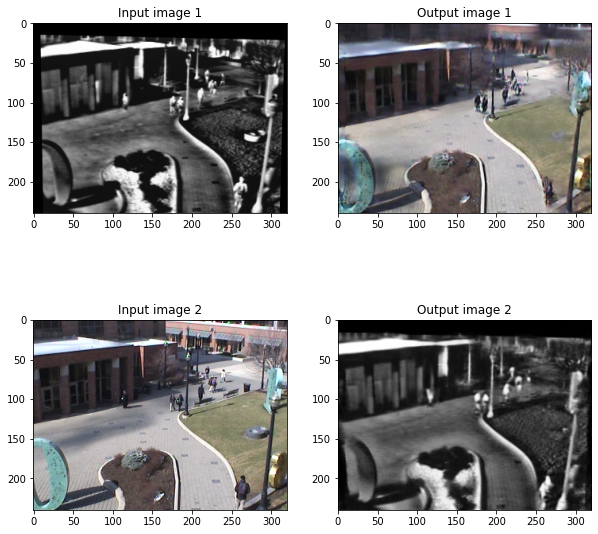

In [ ]:
transform_list = [transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))]
#transform_list = [transforms.RandomCrop((256, 256))] + transform_list
#transform_list = [transforms.Resize(256)] + transform_list
transform = transforms.Compose(transform_list)

input_img_aa = Image.open('Rgb-Thermal/trainA/911.bmp').convert('RGB')
input_img_bb = Image.open('Rgb-Thermal/trainB/911.bmp').convert('RGB')

input_img_a = transform(input_img_aa)
input_img_b = transform(input_img_bb)

trainer = UNIT_Trainer(config)
trainer.cuda()

state_dict = torch.load('GAN1/outputs/rgb-thermal/checkpoints/gen_00400000.pt')
trainer.gen_a.load_state_dict(state_dict['a'])
trainer.gen_b.load_state_dict(state_dict['b'])

encode = trainer.gen_a.encode
style_encode = trainer.gen_b.encode
decode = trainer.gen_b.decode
style_decode = trainer.gen_a.decode

with torch.no_grad():
    input1 = Variable(input_img_a.unsqueeze(0).cuda())
    content, _ = encode(input1)
    outputs = decode(content)
    outputs = (outputs + 1) / 2.
    output_img_b = outputs.cpu()

    input2 = Variable(input_img_b.unsqueeze(0).cuda())
    content, _ = style_encode(input2)
    outputs = style_decode(content)
    outputs = (outputs + 1) / 2.
    output_img_a = outputs.cpu()


fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.title.set_text('Input image 1')
plt.imshow(input_img_aa)

ax2 = fig.add_subplot(2,2,4)
ax2.title.set_text('Output image 2')
plt.imshow(output_img_a[0].permute(1,2,0))

ax3 = fig.add_subplot(2,2,3)
ax3.title.set_text('Input image 2')
plt.imshow(input_img_bb)

ax4 = fig.add_subplot(2,2,2)
ax4.title.set_text('Output image 1')
plt.imshow(output_img_b[0].permute(1,2,0))

input_img_a = np.array(input_img_a)
output_img_b = np.array(output_img_b[0])
input_img_b = np.array(input_img_b)
output_img_a = np.array(output_img_a[0])

print("Train Errors : ")
print("\t MAD for Thermal -> RGB : ",np.mean(np.abs(input_img_a-output_img_a)))
print("\t MAD for RGB -> Thermal : ",np.mean(np.abs(input_img_b-output_img_b)))